## Designing a Cloud Storage Service like Dropbox or Google Drive
Cloud file storage enables uses to store their data on remote servers.

Why cloud storage?
1. **Availability:** Users can access their files from any devices, anywhere, anytime.
2. **Durability and Reliability:** Cloud storage ensures that users never lose their data by storing their data on different geographically located servers.
3. **Scalability:** Users will never have to worry about running out of storage space, as long as they are ready to pay for it.



## 1. Requirements and System Goals
Wht do we want to achieve from a cloud storage system?
1. Users should be able to upload/download files from any devices
2. Users should be aable to share files and folders with other users
3. The service should support large files
4. The service should allow syncing of files between devices. Updating a file on a device should get synchronized on all other devices.
5. ACID-ity on all file operations should be enforced.
6. The service should support offline editing, and as soon as users come online, all changes synced.
7. The service should support snapshotting of data, so that users can go back to previous versions of it

#### Design Considerations
- We should expect large read and write volumes, with the read/write ratio being about the same.
- Files must be stored in small chunks. This has a lot of benefits, such as if a user fails to upload a file, then only the failing chunk will be retried instead of the entire file.
- We can reduce on data exchange by transferring updated chunks only. And, for small changes, clients can intelligently upload the diffs instead of the whole chunk
- The system can remove duplicate chunks, to save storage space and bandwidth.
- We can prevent lots of round trips to the server if clients keep a local copy of metadata (file name, size etc)

## 2. Capacity Estimation
```python
* Assume: 100 million users, 20 million daily active users
* Assume: Each user has on average two devices
* Assume: Each user has on average about 100 files/photos/videos, we have 
100000000 users * 100 files => 10 billion files
* Assume: Average file size => 100KB, Total storage would be: 
        0.1MB * 10B files => 1 PB(Petabyte)
```



## 3. High Level Design

The user will have a folder as their workplace on their device. Any file/photo/folder placed inside this folder will be uploaded to the cloud. If changes are made to it, it will be reflected in the same way in the cloud storage.
- We need to store files and metadata (file name, size, dir, etc) and who the file is shared with.
- We need block servers that to help the clients upload/download files to our service
- We need metadata servers to facilitate updating file and user metadata.
- We need a synchronization server to notify clients whenever an update happens so they can start synchronizing the updated files.
- We need to keep metadata of files updated in a NoSQL database.

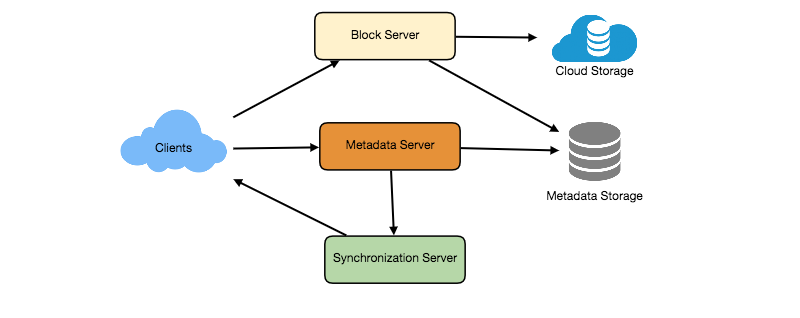